In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torchvision import transforms,datasets
import zipfile
import shutil
import os
import io
import pandas as pd

In [2]:
device=("cuda" if torch.cuda.is_available() else "CPU")

In [3]:
class AlexNet(nn.Module):#recibe imagenes
  def __init__(self,num_clases:int=2):
    super(AlexNet,self).__init__()
    self.convolutional=nn.Sequential(
        nn.Conv2d(3,96,kernel_size=11,stride=4,padding=2),#genera 94 capas de 56x56
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3,stride=2),
        nn.Conv2d(96,256,kernel_size=5,padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3,stride=2),
        nn.Conv2d(256,384,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(384,384,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(384,256,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3,stride=2)
    )
    self.avgpool=nn.AdaptiveAvgPool2d((6,6))
    self.linear=nn.Sequential(
        nn.Dropout(0.5),#se apaga en 50 % de las neuronas para que aprendan las demas
        nn.Linear(256*6*6,4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096,4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096,2)#2 neuronas a la salida gato o perro
    )
  def forward(self,x0: torch.Tensor)-> torch.Tensor:
    x1=self.convolutional(x0)
    x2=self.avgpool(x1)#promedia
    x3=torch.flatten(x2,1)#lo vuelve vector
    x4=self.linear(x3)#regresa clases
    return torch.softmax(x4,1)#regresa un porcentaje

In [4]:
modelo=AlexNet()
modelo=modelo.to(device)

In [5]:
from google.colab import files
uploader=files.upload()

Saving baseDatosDogCat.zip to baseDatosDogCat.zip


In [6]:
datos=zipfile.ZipFile(io.BytesIO(uploader['baseDatosDogCat.zip']),'r')
datos.extractall("perros_gatos/")

In [7]:
root='perros_gatos/data_base_dog_cat'
img_list=os.listdir(root)
print(len(img_list))

1000


In [8]:
basedatos=pd.read_csv('perros_gatos/lista_dog_cat.csv')
basedatos=basedatos[['Nombre','Categoria']]
print(basedatos)

               Nombre  Categoria
0      canino (1).jpg          1
1     canino (10).jpg          1
2    canino (100).jpg          1
3    canino (101).jpg          1
4    canino (102).jpg          1
..                ...        ...
995    perro (95).jpg          1
996    perro (96).jpg          1
997    perro (97).jpg          1
998    perro (98).jpg          1
999    perro (99).jpg          1

[1000 rows x 2 columns]


In [9]:
!rm -rf datos
!mkdir datos && mkdir datos/perros && mkdir datos/gatos

In [10]:
#### Codigo para acceder a la carpeta donde los nombres de las imagenes estaban revueltos ####
s0=0
s1=0
num=1000
for i, (_,i_row) in enumerate(basedatos.iterrows()):
  if s0<num:
    if i_row['Categoria']==1:
      s0 += 1
      shutil.copyfile('perros_gatos/data_base_dog_cat/'+i_row['Nombre'],'datos/perros/'+i_row['Nombre'])
  if s1<num:
    if i_row['Categoria']==0:
      s1+=1
      shutil.copyfile('perros_gatos/data_base_dog_cat/'+i_row['Nombre'],'datos/gatos/'+i_row['Nombre'])
  if s0==num and s1==num:
    break

In [11]:
img_list=os.listdir('datos/perros/')
img_list.extend(os.listdir('datos/gatos/'))
!rm -rf 'datos/ipynb_checkpoints/'
#se pasa a tensor
transformar=transforms.Compose([transforms.ToTensor(),transforms.Resize((224,224)),transforms.Normalize(mean=[0.485, 0.456,0.406], std=[0.229,0.224,0.225])])
clases=datasets.ImageFolder('datos',transform=transformar)
entrenamiento,testeo=torch.utils.data.random_split(clases,[int(len(img_list)*0.8),len(img_list)-int(len(img_list)*0.8)])
cargar_entrenamiento=torch.utils.data.DataLoader(entrenamiento,batch_size=32,shuffle=True)
cargar_testeo=torch.utils.data.DataLoader(testeo,batch_size=16,shuffle=True)

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

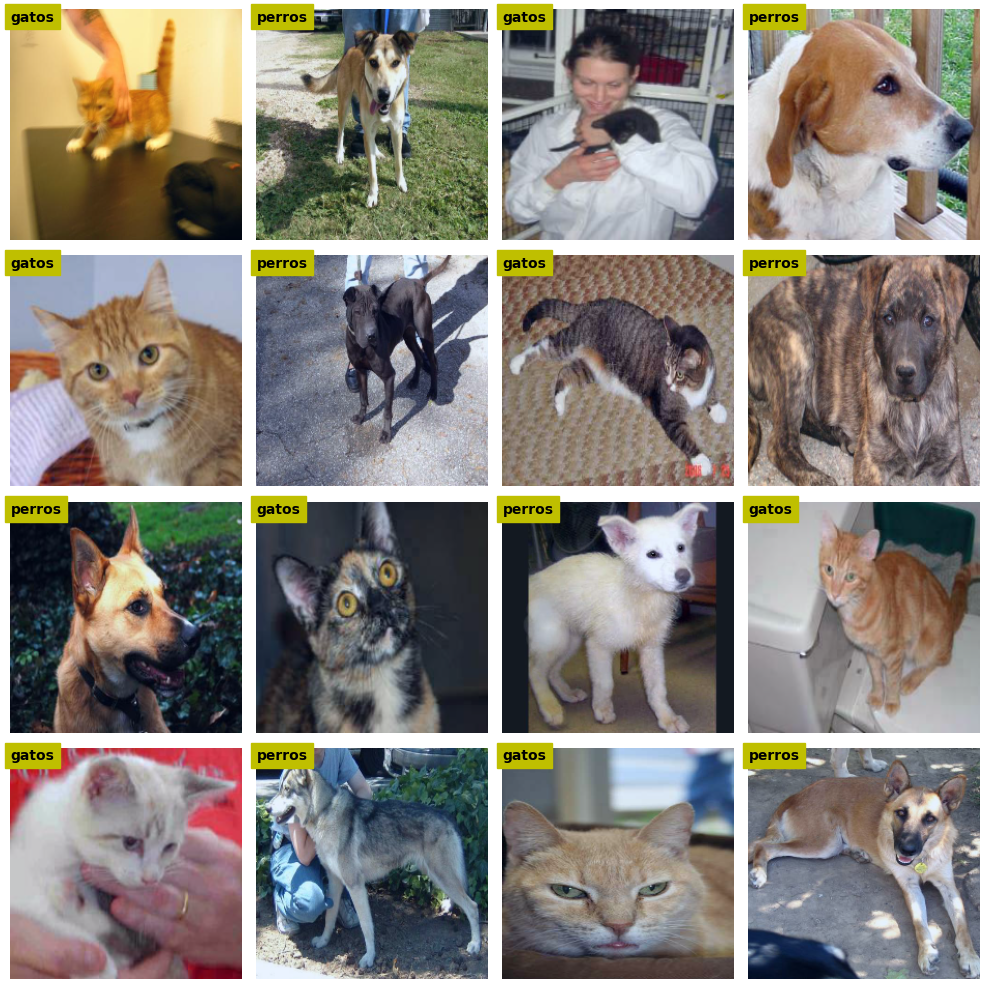

In [12]:
x,y=next(iter(cargar_entrenamiento))
fig, axs =plt.subplots(4,4, figsize=(10,10))
for(i, ax) in enumerate(axs.flatten()):
  pic=x.data[i].numpy().transpose((1,2,0))
  pic=pic-np.min(pic)
  pic=pic/np.max(pic)
  label=clases.classes[y[i]]
  ax.imshow(pic)
  ax.text(0,0,label,ha='left', va='top',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')
plt.tight_layout()
plt.show

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


epoca: 0|error de entrenamiento:0.6749006533622741
epoca: 1|error de entrenamiento:0.6664856171607971
epoca: 2|error de entrenamiento:0.6189183473587037
epoca: 3|error de entrenamiento:0.615932641029358
epoca: 4|error de entrenamiento:0.5979770946502686
epoca: 5|error de entrenamiento:0.6240553331375122
epoca: 6|error de entrenamiento:0.5943245947360992
epoca: 7|error de entrenamiento:0.5836107754707336
epoca: 8|error de entrenamiento:0.5643722701072693
epoca: 9|error de entrenamiento:0.5532353949546814
epoca: 10|error de entrenamiento:0.5404271697998047
epoca: 11|error de entrenamiento:0.5082132077217102
epoca: 12|error de entrenamiento:0.5272991132736206
epoca: 13|error de entrenamiento:0.5013894271850586
epoca: 14|error de entrenamiento:0.48835129261016846
epoca: 15|error de entrenamiento:0.5547849857807159
epoca: 16|error de entrenamiento:0.5191594386100769
epoca: 17|error de entrenamiento:0.47904793739318846
epoca: 18|error de entrenamiento:0.4759380066394806
epoca: 19|error de en

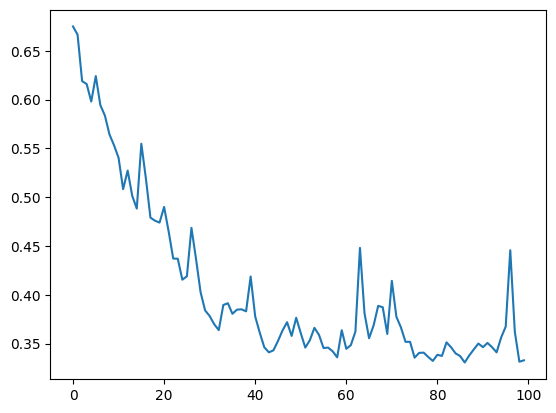

In [14]:
optimizador=optim.Adam(modelo.parameters(),lr=0.0001) #optimizador donde se usa uno de gradiente adaptable usando valores anteriores a razon de aprendizaje de 0.0001
criterio=nn.CrossEntropyLoss()#entropia del error 
epocas=100
errorT=[]#variable que guarda en error cada epoca
for epoca in range(epocas):#cada epoca se prueban las 800 imagenes del entrenamiento
  errorTotal=0
  for idx,(image,label) in enumerate(cargar_entrenamiento):
    image,label=image.to(device),label.to(device)#si hay cuda se puede correr en un gpu
    optimizador.zero_grad()#tendencia del gradiente
    prediccion=modelo(image) #a alexnet se carga la imagen
    error=criterio(prediccion,label)#error con lo que se tiene en la neurona vs lo que quiero
    errorTotal+= error.item()#acumula el error total
    error.backward()# actualiza con backpropagation
    optimizador.step()#da un paso
  errorTotal=errorTotal/(idx+1)#error promedio
  errorT.append(errorTotal)
  print(f'epoca: {epoca}|error de entrenamiento:{errorTotal}')
  for idx,(image,label) in enumerate(cargar_testeo):
      image,label=image.to(device),label.to(device)#si hay cuda se puede correr en un gpu
      with torch.no_grad():
        salida=modelo(image)
        error=criterio(salida,label)
plt.plot(errorT)


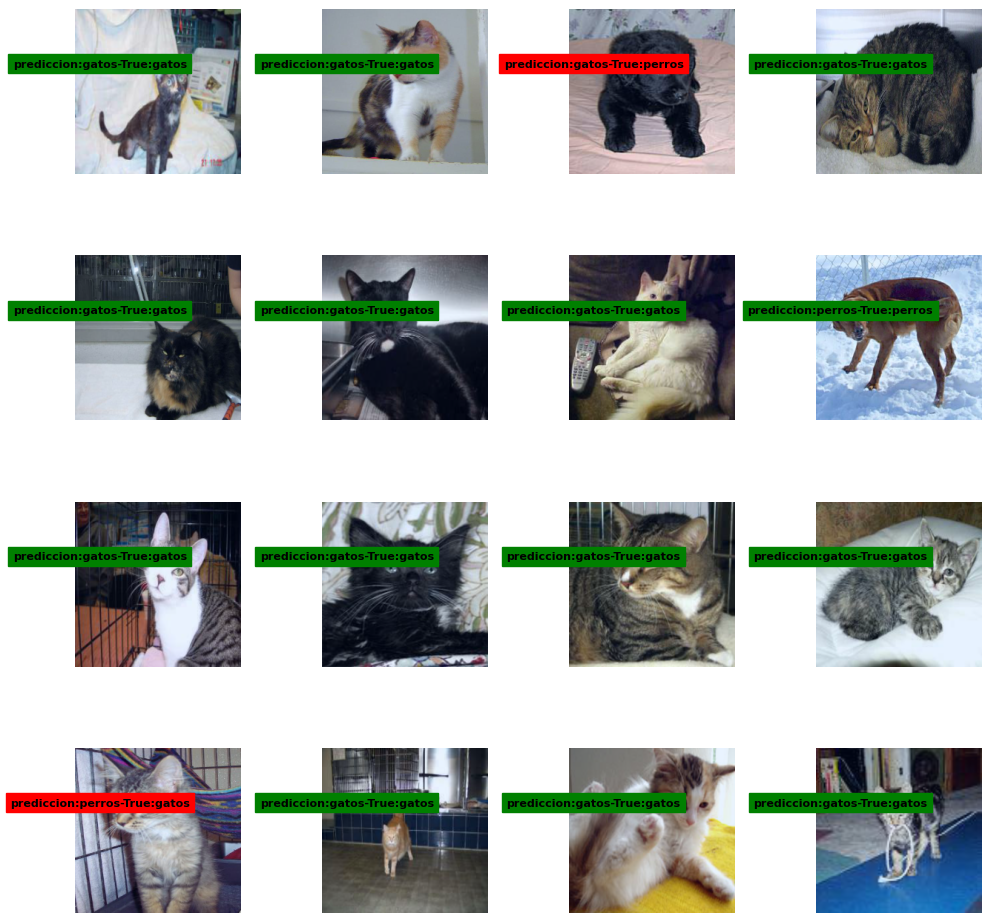

In [35]:
xx, yy=next(iter(cargar_testeo))
xx=xx.to(device)#IMAGENES
yy=yy.to(device)#ETIQUETAS
with torch.no_grad():
  pre_test=torch.argmax(modelo(xx),axis=1)#CARGA LAS 200 IMAGENES
fig, axs=plt.subplots(4,4,figsize=(10,10))#SE VEN IMGS
for (i, ax) in enumerate(axs.flatten()):
  PIC=xx.data[i].cpu().numpy().transpose((1,2,0))
  PIC=PIC-np.min(PIC)
  PIC=PIC/np.max(PIC)
  ax.imshow(PIC)
  label=clases.classes[pre_test[i]]
  truec=clases.classes[yy[i]]
  title=f'prediccion:{label}-True:{truec}'
  titulo='g' if truec ==label else 'r'
  ax.text(33,67,title,ha='center',va='top',fontweight='bold',color='k',backgroundcolor=titulo,fontsize=8)
  ax.axis('off')
plt.tight_layout()
plt.show()